In [90]:
import netCDF4 as nc
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date
from matplotlib.colors import LinearSegmentedColormap

In [25]:
dt_parse = '%Y%m'
def get_date_num(stri):
    date1 = datetime.datetime.strptime(stri, dt_parse)
    return(date.toordinal(date1.date()))
list_of_paths = glob.glob('C:/Users/Patrick/Desktop/175_final/global_fwi_analysis/FWI_nc\'s/*.nc', recursive=True)
nc_list = []
nc_date_list = []
nc_date_key = []
nc_date_int = []
for path in list_of_paths:
    nc_list.append(nc.Dataset(path))
    nc_date_list.append(get_date_num(path[-9:-3]))
    nc_date_key.append(path[-9:-3])

In [34]:
normed_date = np.round(np.array(nc_date_list) - np.mean(np.array(nc_date_list)))
print(len(normed_date))


476


In [24]:
fwi = []
for i in nc_list:
    fwi.append(i['MERRA2_FWI'][0])
fwi_array = np.dstack(fwi)

<ipython-input-24-9e0b1f9b52d8>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fwi.append(i['MERRA2_FWI'][0])
<ipython-input-24-9e0b1f9b52d8>:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  fwi.append(i['MERRA2_FWI'][0])


In [ ]:
years = list(range(1985, 2019))
for i in range(len(years)):
    years[i] = str(years[i])
print(years)
yearly_list = []

for year in years:
    temp_array_list = []
    for i in range(476):
        if(nc_date_key[i][0:4] == year):
            temp_array_list.append(fwi_array[:,:,i])
    print(len(temp_array_list))
    avg_array = np.empty((267,576))
    avg_array[:] = np.nan
    for j in range(267):
        for k in range(576):
            point_list = []
            for q in range(len(temp_array_list)):
                point_list.append(temp_array_list[q][j,k])
            avg_array[j,k] = np.nanmean(np.array(point_list))
    yearly_list.append(avg_array)

In [10]:
year_from_start = np.array(list(range(34)))
yearly_array = np.dstack(yearly_list)

In [52]:
t_trend_slope = np.empty([267, 576])
t_trend_intercept = np.empty([267, 576])
t_trend_rvalue = np.empty([267, 576])
t_trend_pvalue = np.empty([267, 576])
t_trend_stderr = np.empty([267, 576])

t_fwi_point = np.empty([476])
for i in range(267):
    for j in range(576):
        t_fwi_point = fwi_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(t_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(t_fwi_point) & ~np.isnan(normed_date)
            t_trend_slope[i,j], t_trend_intercept[i,j], t_trend_rvalue[i,j], t_trend_pvalue[i,j], t_trend_stderr[i,j] = stats.linregress(normed_date[mask], t_fwi_point[mask])
        else:
            t_trend_slope[i,j] = np.float('NaN')
            t_trend_pvalue[i,j] = np.float('NaN')
            
fwi_detrend = np.empty((267, 576, 476))
for i in range(476):
    fwi_detrend[:,:,i] = fwi_array[:,:,i] - normed_date[i]*t_trend_slope[:,:]        

<ipython-input-52-faa5476ef3b4>:12: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(t_fwi_point)))):


In [48]:
print(len(difference(fwi_detrend[200,150,:], 360)))

116


In [53]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
fwi_re_season = np.empty([267, 576, 464]) 
for i in range(267):
    for j in range(576):
        fwi_re_season[i,j,:] = difference(fwi_detrend[i,j],12)

In [88]:
def three_month_avg(dataset, index):
    temp_array = np.empty([267,576])
    for i in range(267):
        for j in range(576):
            temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))
    return(temp_array)
three_month_list = []
for i in range(464):
    three_month_list.append(three_month_avg(fwi_re_season, i))
    print(str((i/464)*100)+'%')
    
    

<ipython-input-88-6cac96dea5a6>:5: RuntimeWarning: Mean of empty slice
  temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))


0.0%
0.21551724137931033%
0.43103448275862066%
0.646551724137931%
0.8620689655172413%


KeyboardInterrupt: 

In [84]:
print(np.shape(fwi_re_season))

(267, 576, 464)


In [69]:
oni_raw = np.genfromtxt('oni.csv', delimiter=',')
#print(np.shape(oni_raw))
oni_list = []
for i in range(39):
    for j in range(12):
        oni_list.append(oni_raw[i,j])
ONI = np.array(oni_list[:464])
#print(len(ONI))



(39, 12)
464
-9.85935337106413e-06 0.3195165574417809
0.0017988220236655281


In [16]:
forest_cover = np.genfromtxt('deforestation.csv', delimiter = ',')
forest_cover_array = forest_cover[0]
deforestation = forest_cover_array - np.nanmean(forest_cover_array)

d_trend_slope, d_trend_intercept, d_trend_rvalue, d_trend_pvalue, d_trend_stderr = stats.linregress(year_from_start, deforestation)
#print(d_trend_slope, d_trend_pvalue)
deforestation_detrend = deforestation - d_trend_slope*year_from_start
#plt.plot(amazon_detrend)

In [82]:
coef_ONI = np.empty([267, 576])

oni_fwi_point = np.empty([464])
for i in range(267):
    for j in range(576):
        oni_fwi_point = fwi_re_season[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point[3:]) & ~np.isnan(ONI[:-3])
            coef_ONI[i,j] = (np.corrcoef(ONI[:-3][mask], oni_fwi_point[3:][mask]))[0,1]
        else:
            coef_ONI[i,j] = np.float('NaN')

<ipython-input-82-763f925bd56d>:8: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):


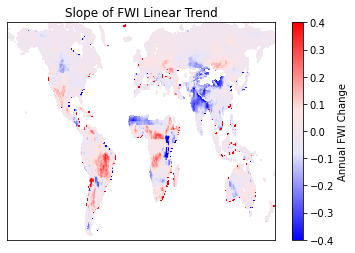

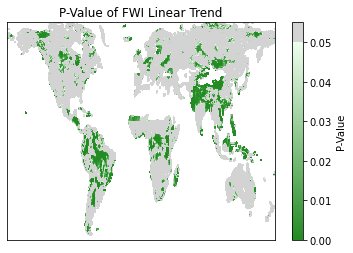

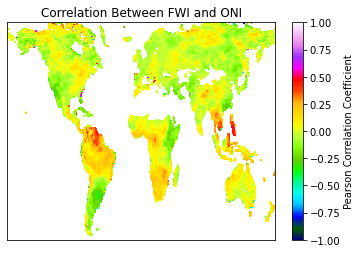

In [149]:
plt.figure(1)
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.figure(2)
colors2 = ['forestgreen', 'honeydew','lightgrey', 'lightgrey']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue, cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.figure(3)
plt.pcolormesh(coef_ONI, vmin=-1, vmax=1, cmap = 'gist_ncar')
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between FWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
#plt.figure(4)
#plt.pcolormesh(coef_deforestation, vmin=-1, vmax=1)
#plt.colorbar()